# Read in cannabis.csv

In [1]:
import pandas as pd

URL = "https://raw.githubusercontent.com/ekselan/DS-2/master/data/cannabis.csv"
cancsv = pd.read_csv(URL)
print(cancsv.shape)
cancsv.head()

(2351, 6)


,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."


# Create csv dataset from The Strain API


In [2]:
# The Strain API Key

API_KEY = "iZMkqry"

In [3]:
# Import statements for interaction with API
import numpy as np
import requests
import json

In [4]:
import requests
response = requests.get(f"https://strainapi.evanbusse.com/{API_KEY}/searchdata/effects")
print(response.json())

[{'effect': 'Relaxed', 'type': 'positive'}, {'effect': 'Dizzy', 'type': 'negative'}, {'effect': 'Hungry', 'type': 'positive'}, {'effect': 'Euphoric', 'type': 'positive'}, {'effect': 'Happy', 'type': 'positive'}, {'effect': 'Depression', 'type': 'medical'}, {'effect': 'Insomnia', 'type': 'medical'}, {'effect': 'Pain', 'type': 'medical'}, {'effect': 'Stress', 'type': 'medical'}, {'effect': 'Cramps', 'type': 'medical'}, {'effect': 'Creative', 'type': 'positive'}, {'effect': 'Energetic', 'type': 'positive'}, {'effect': 'Talkative', 'type': 'positive'}, {'effect': 'Lack of Appetite', 'type': 'medical'}, {'effect': 'Nausea', 'type': 'medical'}, {'effect': 'Dry Mouth', 'type': 'negative'}, {'effect': 'Headache', 'type': 'medical'}, {'effect': 'Uplifted', 'type': 'positive'}, {'effect': 'Tingly', 'type': 'positive'}, {'effect': 'Paranoid', 'type': 'negative'}, {'effect': 'Sleepy', 'type': 'positive'}, {'effect': 'Fatigue', 'type': 'medical'}, {'effect': 'Headaches', 'type': 'medical'}, {'effec

### Read in data from API

In [5]:
# API call for all strains
url = f"https://strainapi.evanbusse.com/{API_KEY}/strains/search/all"
JSONContent = requests.get(url).json()
content = json.dumps(JSONContent, indent=3, sort_keys=True) #> Just to print and
# investigate
# print(content)

In [6]:
type(JSONContent)

dict

In [7]:
df = pd.DataFrame.from_dict(JSONContent)
# Transpose for proper shape
df = df.T
# Reset Index
df = df.reset_index()
# Rename old index column
df = df.rename(columns={"index":"strain"})
print(df.shape)
# df.head()

(1970, 5)


In [8]:
df2 = pd.json_normalize(df['effects'])
# df2.head()

In [9]:
type(df2['positive'][0])

list

In [10]:
# Make copy of dataset
data = df.copy()
print(data.shape)
# data.head()

(1970, 5)


In [11]:
# df with effects dictionaries unpacked
df2 = data['effects'].apply(pd.Series)
# Establish foreign key to merge on
df2['id'] = data['id']
print(df2.shape)
# df2.head()

(1970, 4)


In [12]:
# Merge unpacked effects into data
dataset = data.merge(df2, how='inner', on='id')
dataset = dataset.drop('effects', axis=1)
print(dataset.shape)
dataset.head()

(1970, 7)


,strain,id,race,flavors,positive,negative,medical
0,Afpak,1,hybrid,"[Earthy, Chemical, Pine]","[Relaxed, Hungry, Happy, Sleepy]",[Dizzy],"[Depression, Insomnia, Pain, Stress, Lack of A..."
1,African,2,sativa,"[Spicy/Herbal, Pungent, Earthy]","[Euphoric, Happy, Creative, Energetic, Talkative]",[Dry Mouth],"[Depression, Pain, Stress, Lack of Appetite, N..."
2,Afternoon Delight,3,hybrid,"[Pepper, Flowery, Pine]","[Relaxed, Hungry, Euphoric, Uplifted, Tingly]","[Dizzy, Dry Mouth, Paranoid]","[Depression, Insomnia, Pain, Stress, Cramps, H..."
3,Afwreck,4,hybrid,"[Pine, Earthy, Flowery]","[Relaxed, Happy, Creative, Uplifted, Sleepy]","[Dizzy, Dry Mouth, Paranoid, Dry Eyes]","[Pain, Stress, Headache, Fatigue, Headaches, M..."
4,Agent Orange,5,hybrid,"[Citrus, Orange, Sweet]","[Relaxed, Euphoric, Happy, Energetic, Uplifted]","[Dizzy, Dry Mouth, Paranoid, Dry Eyes]","[Depression, Pain, Stress, Nausea, Headache, H..."


In [13]:
dataset.isnull().sum()

strain      0
id          0
race        0
flavors     0
positive    0
negative    0
medical     0
dtype: int64

### Prep data for merge

In [14]:
# Function to wrangle column values

def wrangle(x):
  """ Wrangle column value lists into strings"""
  # flavors column
  flavors = []
  for row in x['flavors']:
    row = str(row)
    row = row.replace("[","") 
    row = row.replace("'","") 
    row = row.replace("]","") 
    flavors.append(row)
  x['flavors'] = flavors

  # positive column
  pos = []
  for row in x['positive']:
    row = str(row)
    row = row.replace("[","") 
    row = row.replace("'","") 
    row = row.replace("]","")
    pos.append(row)
  x['positive'] = pos

  # negative column
  neg = []
  for row in x['negative']:
    row = str(row)
    row = row.replace("[","") 
    row = row.replace("'","") 
    row = row.replace("]","")
    neg.append(row)
  x['negative'] = neg

  # medical column
  med = []
  for row in x['medical']:
    row = str(row)
    row = row.replace("[","") 
    row = row.replace("'","") 
    row = row.replace("]","")
    med.append(row)
  x['medical'] = med
  return x

In [15]:
dataset_clean = dataset.copy()
dataset_clean = wrangle(dataset_clean)
dataset_clean.head()

,strain,id,race,flavors,positive,negative,medical
0,Afpak,1,hybrid,"Earthy, Chemical, Pine","Relaxed, Hungry, Happy, Sleepy",Dizzy,"Depression, Insomnia, Pain, Stress, Lack of Ap..."
1,African,2,sativa,"Spicy/Herbal, Pungent, Earthy","Euphoric, Happy, Creative, Energetic, Talkative",Dry Mouth,"Depression, Pain, Stress, Lack of Appetite, Na..."
2,Afternoon Delight,3,hybrid,"Pepper, Flowery, Pine","Relaxed, Hungry, Euphoric, Uplifted, Tingly","Dizzy, Dry Mouth, Paranoid","Depression, Insomnia, Pain, Stress, Cramps, He..."
3,Afwreck,4,hybrid,"Pine, Earthy, Flowery","Relaxed, Happy, Creative, Uplifted, Sleepy","Dizzy, Dry Mouth, Paranoid, Dry Eyes","Pain, Stress, Headache, Fatigue, Headaches, Mu..."
4,Agent Orange,5,hybrid,"Citrus, Orange, Sweet","Relaxed, Euphoric, Happy, Energetic, Uplifted","Dizzy, Dry Mouth, Paranoid, Dry Eyes","Depression, Pain, Stress, Nausea, Headache, He..."


# Merge cannabis.csv with The Strain data

In [16]:
print('TheStrain:', dataset_clean.shape)
print('cancsv:', cancsv.shape)
cancsv = cancsv.rename(columns={"Strain":"strain"})
# cancsv.head()

TheStrain: (1970, 7)
cancsv: (2351, 6)


In [17]:
# Clean strings in strain column to prep for merge

def wrangle_cancsv(x):
  rows = []
  for row in x['strain']:
    row = row.replace("-"," ")
    rows.append(row)
  x['strain'] = rows
  return x

can_clean = wrangle_cancsv(cancsv)

In [18]:
# Merge data
final = dataset_clean.merge(cancsv, how='inner', on='strain')
df = final.copy()
df = df.drop(columns=['race','Effects','Description','negative'])
# Replace empty values with nan
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.dropna()
print(df.shape)
df.head()

(1463, 8)


,strain,id,flavors,positive,medical,Type,Rating,Flavor
0,Afpak,1,"Earthy, Chemical, Pine","Relaxed, Hungry, Happy, Sleepy","Depression, Insomnia, Pain, Stress, Lack of Ap...",hybrid,4.2,"Pine,Spicy/Herbal,Earthy"
1,African,2,"Spicy/Herbal, Pungent, Earthy","Euphoric, Happy, Creative, Energetic, Talkative","Depression, Pain, Stress, Lack of Appetite, Na...",sativa,3.9,"Spicy/Herbal,Pungent,Pepper"
2,Afternoon Delight,3,"Pepper, Flowery, Pine","Relaxed, Hungry, Euphoric, Uplifted, Tingly","Depression, Insomnia, Pain, Stress, Cramps, He...",hybrid,4.8,"Pungent,Citrus,Tropical"
3,Afwreck,4,"Pine, Earthy, Flowery","Relaxed, Happy, Creative, Uplifted, Sleepy","Pain, Stress, Headache, Fatigue, Headaches, Mu...",hybrid,4.2,"Earthy,Pine,Pungent"
4,Agent Orange,5,"Citrus, Orange, Sweet","Relaxed, Euphoric, Happy, Energetic, Uplifted","Depression, Pain, Stress, Nausea, Headache, He...",hybrid,4.2,"Citrus,Orange,Earthy"


In [19]:
df.isnull().sum()

strain      0
id          0
flavors     0
positive    0
medical     0
Type        0
Rating      0
Flavor      0
dtype: int64

# Export dataset to .csv

In [20]:
# df.to_csv("/files/BW_MedCab_Dataset.csv", index=False)

In [21]:
# df.to_csv("/files/BW_MedCab_Dataset_With_Index.csv", index=True)

## NLP

### Tokenize Effects

In [22]:
import spacy
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [23]:
from spacy.tokenizer import Tokenizer

nlp = spacy.load('en_core_web_sm')

STOP_WORDS = nlp.Defaults.stop_words.union(["of"])
text = str(df['medical'])

doc = nlp(text)

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Tokenizer Pipe
tokens = []

"""Make them tokens"""
for doc in tokenizer.pipe(df['medical'], batch_size=500):

  doc_tokens = []

  for token in doc:
    if token.text.lower() not in STOP_WORDS:
      doc_tokens.append(token.text.lower())

  tokens.append(doc_tokens)

df['tokens'] = tokens

In [24]:
type(tokens)

list

In [25]:
df['tokens'][0]

['depression,', 'insomnia,', 'pain,', 'stress,', 'lack', 'appetite']

### Get Word Counts for Medical Effects

In [26]:
!pip install squarify

In [27]:
from collections import Counter
import squarify

def count(docs):
    """
    Function which takes a corpus of document and returns a dataframe
    of word counts to analyze.
    """

    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

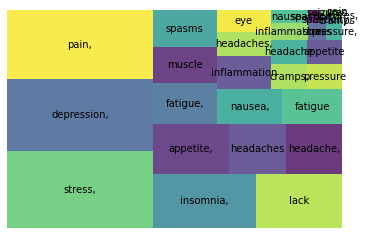

In [28]:
import matplotlib.pyplot as plt

wc = count(df['tokens'])

wc_top20 = wc[wc['rank'] <= 30]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [29]:
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
5,"stress,",1283,1283,1.0,0.153267,0.153267,0.876965
0,"depression,",1209,1209,2.0,0.144427,0.297694,0.826384
1,"pain,",1148,1148,3.0,0.137140,0.434835,0.784689
2,"insomnia,",634,634,4.0,0.075738,0.510572,0.433356
4,lack,532,532,5.0,0.063553,0.574125,0.363636
8,"appetite,",438,438,6.0,0.052323,0.626448,0.299385
15,headaches,328,328,7.0,0.039183,0.665631,0.224197
12,"headache,",325,325,8.0,0.038825,0.704456,0.222146
10,"fatigue,",298,298,9.0,0.035599,0.740055,0.203691
11,muscle,268,268,10.0,0.032015,0.772070,0.183185


### TF-IDF feature matrix

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer


# List of text documents
data = list(df['medical'])

# create the transformer
tfidf = TfidfVectorizer(max_df=.95,
                       min_df=2,
                       ngram_range=(1,3),
                       max_features=5000)

# build vocab
dtm = tfidf.fit_transform(data) #> Similar to fit_predict

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,appetite,appetite eye,appetite eye pressure,appetite fatigue,appetite fatigue eye,appetite fatigue headaches,appetite fatigue inflammation,appetite fatigue muscle,appetite fatigue spasticity,appetite headache,appetite headache eye,appetite headache fatigue,appetite headache headaches,appetite headache inflammation,appetite headache muscle,appetite headaches,appetite headaches eye,appetite headaches inflammation,appetite headaches muscle,appetite inflammation,appetite inflammation muscle,appetite muscle,appetite muscle spasms,appetite nausea,appetite nausea eye,appetite nausea fatigue,appetite nausea headache,appetite nausea headaches,appetite nausea inflammation,appetite nausea muscle,appetite spasticity,cramps,cramps fatigue,cramps fatigue eye,cramps fatigue headaches,cramps headache,cramps headaches,cramps headaches eye,cramps headaches inflammation,cramps inflammation,...,stress cramps headaches,stress cramps inflammation,stress cramps lack,stress cramps muscle,stress cramps nausea,stress eye,stress eye pressure,stress fatigue,stress fatigue eye,stress fatigue headaches,stress fatigue inflammation,stress fatigue muscle,stress fatigue spasticity,stress headache,stress headache eye,stress headache fatigue,stress headache headaches,stress headache inflammation,stress headache muscle,stress headache spasticity,stress headaches,stress headaches eye,stress headaches inflammation,stress headaches muscle,stress inflammation,stress inflammation muscle,stress inflammation spasticity,stress lack,stress lack of,stress muscle,stress muscle spasms,stress nausea,stress nausea eye,stress nausea fatigue,stress nausea headache,stress nausea headaches,stress nausea inflammation,stress nausea muscle,stress seizures,stress spasticity
0,0.245645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.264710,0.264710,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.178396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.330506,0.0,0.0,0.417541,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.192242,0.192242,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.270812,0.0,0.0,0.0,0.524862,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217233,0.0,0.274628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.281438,0.0,0.0,0.359183,0.0,0.0,0.0,0.0,0.0


### Create NearestNeighbor Model

In [31]:
!pip install --user --upgrade scikit-learn==0.23.1

     |████████████████████████████████| 6.9MB 2.8MB/s 


In [32]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [33]:
len(data)

1463

In [34]:
df.shape

(1463, 9)

In [35]:
data[400]

'Depression, Pain, Nausea, Eye Pressure, Inflammation'

In [36]:
## Test NN model

symptoms = ["Tired, Sleepy, Stress, Pain"]

# Query for symptoms
new = tfidf.transform(symptoms)

nn.kneighbors(new.todense())

(array([[0.65826206, 0.65826206, 0.65826206, 0.71240078, 0.81771129]]),
 array([[1403,  358,  490,  729,  494]]))

In [37]:
data[1403]

'Pain, Stress'

In [38]:
df.iloc[1403]

strain                         West Coast Dawg
id                                        2076
flavors                 Sweet, Tropical, Woody
positive    Relaxed, Euphoric, Sleepy, Aroused
medical                           Pain, Stress
Type                                    indica
Rating                                     4.8
Flavor                       Sweet,Woody,Nutty
tokens                         [pain,, stress]
Name: 1433, dtype: object

### Work on function / output

In [39]:
def hello_neighbor():

  # Get user provided string
  x = input()

  # Query for symptoms
  new = tfidf.transform(symptoms)

  # Run model
  result = nn.kneighbors(new.todense())


  return result

In [40]:
symptoms = ["Tired, Sleepy, Stress, Pain"]

# Query for symptoms
new = tfidf.transform(symptoms)

result = nn.kneighbors(new.todense())

In [41]:
len(result)

2

In [42]:
type(result)

tuple

In [43]:
result

(array([[0.65826206, 0.65826206, 0.65826206, 0.71240078, 0.81771129]]),
 array([[1403,  358,  490,  729,  494]]))

In [44]:
result[0]

array([[0.65826206, 0.65826206, 0.65826206, 0.71240078, 0.81771129]])

In [45]:
result[1]

array([[1403,  358,  490,  729,  494]])

In [46]:
result[1][0][0]

1403

In [52]:
result[1][0]

array([1403,  358,  490,  729,  494])

In [47]:
sorted(result[1])[0][0]

1403

In [48]:
num = result[1][0][0]

info = df.iloc[num]

print(info)

strain                         West Coast Dawg
id                                        2076
flavors                 Sweet, Tropical, Woody
positive    Relaxed, Euphoric, Sleepy, Aroused
medical                           Pain, Stress
Type                                    indica
Rating                                     4.8
Flavor                       Sweet,Woody,Nutty
tokens                         [pain,, stress]
Name: 1433, dtype: object


#### Incorporate details of strain in model predict function

In [49]:
def hello_neighbor():

  # Get user provided string
  x = input() #> this will take-in input from a route

  # Query for symptoms
  new = tfidf.transform([x])

  # Run model
  result = nn.kneighbors(new.todense())

  # Get index location of recommended strain
  num = result[1][0][0]

  # Include all details of strain except Flavor, tokens, data
  info = df.iloc[num][:7] #> could swap this to database query

  # Possibly grab top 5, loop them and grab their info

  return "Your Recommended Strain:", info

In [50]:
hello_neighbor()

hungry, tired, sad


('Your Recommended Strain:',
 strain                                         King Cake
 id                                                  1167
 flavors                           Sweet, Vanilla, Citrus
 positive    Relaxed, Euphoric, Happy, Creative, Uplifted
 medical           Stress, Lack of Appetite, Eye Pressure
 Type                                              hybrid
 Rating                                               4.8
 Name: 798, dtype: object)

In [51]:
hello_neighbor()

swollen, spasms, aches


('Your Recommended Strain:', strain                              Mission Kush
 id                                          1370
 flavors                                     Pine
 positive    Euphoric, Happy, Creative, Energetic
 medical                            Muscle Spasms
 Type                                      hybrid
 Rating                                         4
 Name: 934, dtype: object)

In [52]:
df.iloc[100][:7]

strain                                  Big Holy Nina
id                                                247
flavors                        Earthy, Pungent, Woody
positive         Euphoric, Happy, Talkative, Uplifted
medical     Stress, Lack of Appetite, Nausea, Fatigue
Type                                           hybrid
Rating                                              4
Name: 102, dtype: object

### Pickle Model

In [53]:
# Pickle (trained) model here
# Dont use model.dump use model.save instead

import pickle

# Save the trained model as a pickle string
saved_model = pickle.dumps(nn)

# Load the pickled model
nn_from_pickle = pickle.loads(saved_model)

In [56]:
# Pickle model with filepath for export
MODEL_FILEPATH = "/pickling/medcab_model2.pkl"

with open(MODEL_FILEPATH, "wb") as model_file:
  pickle.dump(nn, model_file)

In [55]:
import sklearn
sklearn.__version__
# Updated version after initially loading in pickled model to local env
# and getting warning regarding loading a pickled model from different sklearn
# version than my environment 

'0.23.1'

### Pickled model test

In [70]:
def hello_pickle():

  # Get user provided string
  x = input() #> this will take-in input from a route

  # Query for symptoms
  new = tfidf.transform([x])

  # Run model
  result = nn_from_pickle.kneighbors(new.todense())

  # Get index location of recommended strain
  num = result[1][0][0]

  # Include all details of strain except Flavor, tokens, data
  info = df.iloc[num][:7] #> could swap this to database query

  # Possibly grab top 5, loop them and grab their info

  return "Your Recommended Strain:", info

In [71]:
hello_pickle()

spasms


('Your Recommended Strain:', strain                              Mission Kush
 id                                          1370
 flavors                                     Pine
 positive    Euphoric, Happy, Creative, Energetic
 medical                            Muscle Spasms
 Type                                      hybrid
 Rating                                         4
 Name: 934, dtype: object)

In [60]:
def hello_new_pickle():

  # Get user provided string
  x = input() #> this will take-in input from a route

  # Query for symptoms
  new = tfidf.transform([x])

  # Run model
  result = nn.kneighbors(new.todense())

  # Get index location of recommended strain
  # num = result[1][0][0]

  summary = []
  for r in result[1][0]:
    info = df.iloc[r][:7]
    summary.append(info)

  # Possibly grab top 5, loop them and grab their info

  return "Your Recommended Strain:", summary

In [55]:
locs = []
for r in result[1][0]:
  info = df.iloc[r][:7]
  locs.append(info)

locs

In [61]:
hello_new_pickle()

insomnia, pressure, anxiety


('Your Recommended Strain:', [strain                    The Sheriff
  id                               1974
  flavors                 Earthy, Woody
  positive    Relaxed, Uplifted, Sleepy
  medical                  Eye Pressure
  Type                           hybrid
  Rating                              4
  Name: 1361, dtype: object, strain                        Doobiebird Daydream
  id                                            696
  flavors                   Blueberry, Earthy, Pine
  positive    Relaxed, Euphoric, Creative, Uplifted
  medical                   Headaches, Eye Pressure
  Type                                       hybrid
  Rating                                        4.6
  Name: 450, dtype: object, strain                                        Tangie Dream
  id                                                    1944
  flavors                              Citrus, Orange, Sweet
  positive    Relaxed, Hungry, Euphoric, Creative, Talkative
  medical                      